***This notebook was developed by On-Prem Cloud team member Brian Bonnlander***

# NCAR Research Data Archive (RDA) Data:  Local Access Options

Most, or perhaps all, of data from the RDA is available on NCAR's local file storage systems.

For users with access to NCAR compute servers and storage, there are two repositories available:

*  Glade, a high-speed file storage system
*  Stratus, an object storage system

We will go over detailed examples for both cases below, using an example with surface wind data.

### Use Case:   Wind Farm Productivity Analysis

Suppose someone wants to know the potential amount of electricity that could be generated from a wind farm near Cheyenne, Wyoming.   This means knowing something about the wind speeds in the area, which could vary with the seasons. We might be interested in looking at wind speeds over a single season, or wind speeds over several consecutive years.   In this notebook, we will demonstrate how to do both.

The RDA Thredds Data Server has this dataset with surface wind observational data: [ERA5 Reanalysis (0.25 Degree Latitude-Longitude Grid)](https://rda.ucar.edu/datasets/ds633-0/)

Among the available data products is a global atmospheric surface analysis in either GRIB or NetCDF format.   

Note that we could download the data files directly, but this would be expensive and time-consuming because each data file contains data for the entire globe.  In this example, we care only about one location in Wyoming.  So instead of downloading data for the entire globe, we will use the Xarray and Dask python libraries to load and plot only the data associated with Cheyenne, Wyoming.

We will show how to access this dataset, specify which portion of the dataset we wish to extract, and plot the extracted values.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

import os

Here are a few helper functions for data access and wind speed calculation:

In [2]:
def get_dataset(filepath_pattern, use_grib, parallel):
    """ Given a file pattern specification and a file format type, return an xarray dataset 
        containing data from all matching files.   
        
        `filepath_pattern` must specify a full directory path.  Wildcards may be included to match
        many subdirectories or groups of files.  Wildcard syntax follows bash shell conventions for
        greater flexibility.
        
        If `parallel = True`, use an existing Dask cluster to open data files.
    """
    # If reading GRIB data, disable saving a GRIB index file to the data directory.
    if use_grib:
        filename_extension = '.grb'
        backend_kwargs = {'indexpath': ''}
    else:
        filename_extension = '.nc'    
        backend_kwargs = None
        
    full_pattern = filepath_pattern + filename_extension
    
    # Allow bash-style syntax for file patterns
    file_listing = os.popen(f"/bin/bash -c 'ls {full_pattern}'").read()
    
    # Split the output into lines and ignore empty lines
    file_list = file_listing.split('\n')
    file_list = [filename for filename in file_list if len(filename) > 0]

    # Verify there is at least one matching file
    if len(file_list) == 0:
        raise ValueError(f'No files match the pattern {full_pattern}')
        
    ds = xr.open_mfdataset(file_list, parallel=parallel, backend_kwargs=backend_kwargs) 
    return ds

In [3]:
def get_point_array(dataset, latitude, longitude, varname=None):
    """ Extract and return a DataArray object associated with some lat/lon location.
    A DataArray object is an array of time series values, along with associated metadata.
    
    'dataset' is an xarray dataset
    
    'latitude' is a scalar in the range of the dataset's latitude values.
        
    'longitude' is a scalar in the range of the dataset's longitude values.

    If 'varname' is provided, retrieve values from this data variable.  Otherwise, 
        return values from the first data variable in the dataset.
    """
    # Assert latitude value is in the dataset range
    assert(latitude >= np.min(dataset.coords['latitude'].values))
    assert(latitude <= np.max(dataset.coords['latitude'].values))
    
    # Assert longitude value is in the dataset range
    assert(longitude >= np.min(dataset.coords['longitude'].values))
    assert(longitude <= np.max(dataset.coords['longitude'].values))
    
    # If a data variable name is not provided, use the first data variable.
    if not varname:
        data_vars = list(dataset.data_vars.keys())
        varname = data_vars[0]
        
    point_array = dataset[varname].sel(latitude=latitude, longitude=longitude, method='nearest')
    return point_array


In [4]:
def wind_speed(u, v, units=None):
    """Compute the wind speed from u and v-component numpy arrays.
       If units is 'mph', convert from "meters per second" to "miles per hour".
    """
    speed = np.hypot(u, v)
    if units == 'mph':
        speed = 2.369 * speed
    return speed

In [5]:
def plot_winds(u_values, v_values, time_values):
    """ Compute wind speed values and plot them on a line plot.
    """
    winds = wind_speed(u_values, v_values, units='mph')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(time_values, winds, color='r')
    ax.set_title('Hourly Average Wind Speeds for Cheyenne, Wyoming')
    ax.set_ylabel('Miles Per Hour')
    return fig

## Local Glade Access


Glade is a multi-petabyte, high availability disk storage system connected to many of NCAR's computing resources.   It is used to store, serve, and process large quantities of numerical data for many users simultaneously.   It provides a UNIX-like interface for accessing files and directories. 

Most, if not all, of RDA's data assets are located in the directory `/glade/campaign/collections/rda/data/`.

In [6]:
# This RDA data directory contains surface analysis data on a 0.25 degree global grid
data_dir = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/'

#### Case 1: Relatively few data files and high CPU availability

If there are relatively few data files to open, and we are not on a shared system under CPU load, then we do not need Dask parallelism to help speed up the loading process.

Here, we construct xarray datasets with the data available for March, April, and May of 2022.   Memory and CPU requirements are not high to obtain this data, but if you are on a heavily used computing system, you may still find it takes a while to load.   If so, see below for how to speed up loading with Dask.

In [7]:
# This bash-style pattern will match data for March, April, and May of 2022.
year_month_pattern = '2022{03,04,05}/'

data_spec = data_dir + year_month_pattern

# These filename patterns refer to u- and v-components of winds at 10 meters above the land surface.
filename_pattern_u = 'e5.oper.an.sfc.228_131_u10n.ll025sc.*'
filename_pattern_v = 'e5.oper.an.sfc.228_132_v10n.ll025sc.*'

# Choose between loading data in GRIB or NetCDF format.  
USE_GRIB = True    

ds_u = get_dataset(data_spec + filename_pattern_u, USE_GRIB, parallel=False)
ds_v = get_dataset(data_spec + filename_pattern_v, USE_GRIB, parallel=False)

/opt/base-conda/cisl-cloud-base/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


The previous step only loaded the structure of the dataset, not the data values.  We can now examine the structure of the dataset, even though the values have not been loaded yet.

In [8]:
ds_v

<xarray.Dataset>
Dimensions:     (time: 2208, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2022-03-01 ... 2022-05-31T23:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    v10n        (time, latitude, longitude) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-01-22T21:58 GRIB to CDM+CF via cfgrib-0.9.1...

The entire dataset contains (2208 x 721 x 1440) = 2.29 billion values, but we are only interested in the 2208 time-indexed values associated with Cheyenne, Wyoming.   By subsetting the data, we reduce the required data I/O by a factor of one million.

By clicking on the disk-shaped icon to the right of V10N above, we can verify that the entire dataset would require at least 8.54 GiB of memory to load.   We will use subsetting to achieve a drastic reduction in time and memory resources.

Unfortunately, the data variable names are slightly different between NetCDF and GRIB data files.
So the following code block assigns the correct data variable names depending on the format.

It's also possible to skip this step because the `get_point_array()` function declared above will use the first data variable if no name is provided.

In [9]:
# Assign the correct variable names depending on the dataset format.
if USE_GRIB:
    var_u = 'u10n'
    var_v = 'v10n'
else:
    var_u = 'U10N'
    var_v = 'V10N'

In [10]:
# Select data for a specific geographic location (Cheyenne, Wyoming).
# Note that dataset longitude values are in the range [0, 360]; click the disk icon to the right of 
#   "longitude" above to verify.
# We convert from longitude values provided by Google in the range [-180, 180] using subtraction.

# A couple of cities to choose from
cheyenne = {'lat': 41.14, 'lon': 360 - 104.82}
boulder =  {'lat': 40.01, 'lon': 360 - 105.27}

city = cheyenne

# Select the nearest grid cell to our lat/lon location.
u = get_point_array(ds_u, city['lat'], city['lon'], var_u)
v = get_point_array(ds_v, city['lat'], city['lon'], var_v)

In [11]:
u

<xarray.DataArray 'u10n' (time: 2208)>
dask.array<getitem, shape=(2208,), dtype=float32, chunksize=(744,), chunktype=numpy.ndarray>
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2022-03-01 ... 2022-05-31T23:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    float64 41.25
    longitude   float64 255.2
    valid_time  (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
Attributes: (12/30)
    GRIB_paramId:                             228131
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           u10n
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre u-component of neutral...
    units:                                    m s**-1
    standard_name:                            unknown

Up to now, only the dataset and DataArray characteristics have been loaded into memory.   The next assignment steps pull the subsetted data values into memory.

In [12]:
%%time 

# Actually load the data into memory.
u_values = u.values
v_values = v.values

CPU times: user 26.8 s, sys: 3.4 s, total: 30.2 s
Wall time: 30.3 s


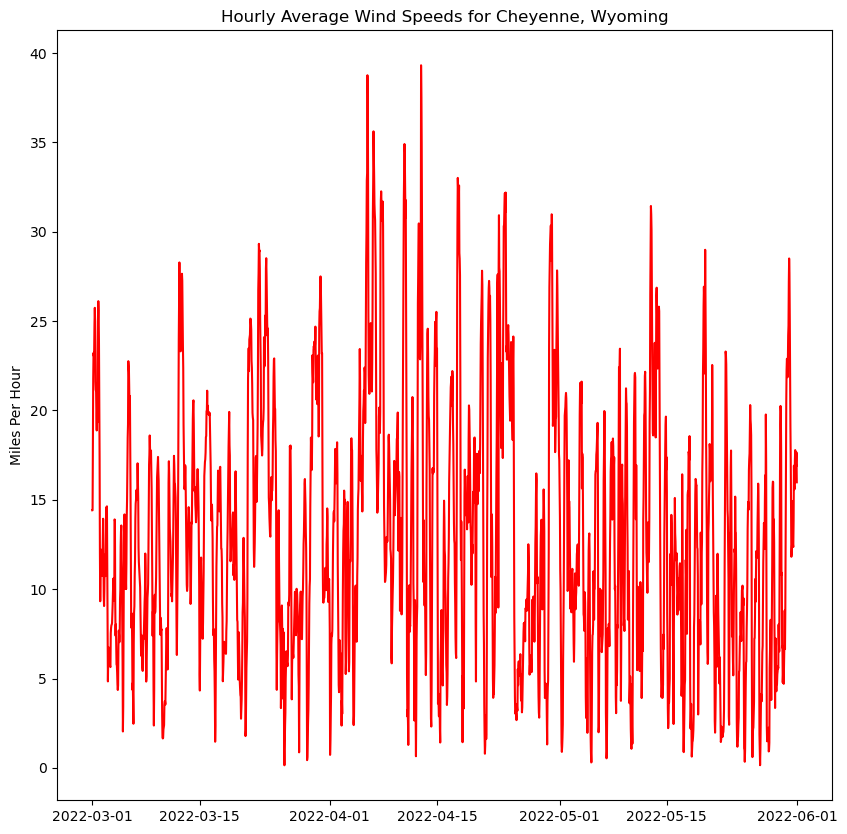

In [13]:
figure = plot_winds(u_values, v_values, ds_u.time)

plt.show()

### Case 2: Opening Many Files or Low CPU Availability

Using Dask to open and extract datasets is a convenient way to speed up the process.   On shared computing systems with PBS job schedulers such as NCAR's Casper cluster, Dask workers can be allocated using separated, dedicated CPU resources.  

In this example, we allocate a Dask cluster with the PBS job scheduler, but it is also possible to allocate Dask clusters using dask_gateway or dask_localcluster, if your system has been configured to allow it.

#### Choose whether to use a PBS Scheduler, Dask Gateway, or LocalCluster to acquire a Dask Cluster

If running on a HPC computer with a PBS Scheduler, set to True.  Otherwise, set to False.

In [14]:
USE_PBS_SCHEDULER = False

If running on Jupyter server with Dask Gateway configured, set to True.  Otherwise, set to False.

In [15]:
USE_DASK_GATEWAY = False

Below we specify the maximum size of our Dask cluster.   On a shared computing system, not all Dask workers may be allocated at the same time, but we can specify the upper limit of the number of Dask workers to allocate.  You can think of each worker as having its own "slice" of CPU and network resources if the underlying hardware is a node-based architecture, with each node having many CPUs that share a network bus.

In [16]:
# Choose the target number of workers for a Dask cluster

MAX_WORKERS = 4

## Create and Connect to Dask Distributed Cluster

In [17]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=MAX_WORKERS)
    return cluster

In [18]:
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    
    num_jobs = MAX_WORKERS
    walltime = '0:10:00'
    memory = '4GB' 

    cluster = PBSCluster(cores=1, processes=1, walltime=walltime, memory=memory, queue='casper', 
                         resource_spec=f"select=1:ncpus=1:mem={memory}",)
    cluster.scale(jobs=num_jobs)
    return cluster

In [19]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster
    cluster = LocalCluster()    

    cluster.scale(MAX_WORKERS)
    return cluster

In [20]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

# Pause notebook execution until some workers have been allocated.
min_workers = 2
client.wait_for_workers(min_workers)

# Display cluster dashboard URL
cluster

LocalCluster(b6b7778f, 'tcp://127.0.0.1:39357', workers=4, threads=32, memory=251.42 GiB)

The following steps are nearly identical to the steps above, but we pull data values for the entire year of 2021 and 2022 using dedicated CPU and memory resources through Dask.  It is enough data that without Dask, you are almost surely going to wait a long time to load all of it.  Note that opening the datasets may be relatively quick, but just before plotting, the data actually gets loaded into memory, and the slowdown can be seen then.

Happily, Dask can speed up the work in a way that scales nearly linearly with the number of workers in the Dask cluster.  In other words, if your cluster has 5 workers, the data should load 5 times faster than when not using Dask.

In [21]:
# This subdirectory contains surface analysis data on a 0.25 degree global grid
data_dir = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/'

# This bash-style pattern will match data for 2021 and 2022.
year_month_pattern = '202{1,2}*/'

data_dir = data_dir + year_month_pattern

# These filename patterns refer to u- and v-components of winds at 10 meters above the land surface.
filename_pattern_u = 'e5.oper.an.sfc.228_131_u10n.ll025sc.*'
filename_pattern_v = 'e5.oper.an.sfc.228_132_v10n.ll025sc.*'

# Choose between loading data in GRIB or NetCDF format.  
USE_GRIB = False    

ds_u = get_dataset(data_spec + filename_pattern_u, USE_GRIB, parallel=True)
ds_v = get_dataset(data_spec + filename_pattern_v, USE_GRIB, parallel=True)

/opt/base-conda/cisl-cloud-base/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
/opt/base-conda/cisl-cloud-base/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
/opt/base-conda/cisl-cloud-base/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
/opt/base-conda/cisl-cloud-base/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py i

In [22]:
# We can see the structure of the dataset, even though the values have not been loaded yet.

ds_v 

<xarray.Dataset>
Dimensions:    (time: 2208, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2022-03-01 ... 2022-05-31T23:00:00
Data variables:
    V10N       (time, latitude, longitude) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r9i1n27 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Sat Jun  4 11:34:50 MDT 2022
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Sat Jun  4 11:35:06 2022: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...

Unfortunately, the data variable names are slightly different between NetCDF and GRIB data files.
So the following code block assigns the correct data variable names depending on the format.

It's also possible to skip this step because the `get_point_array()` function declared above will use the first data variable if no name is provided.

In [23]:
# Assign the correct variable names depending on the dataset format.
if USE_GRIB:
    var_u = 'u10n'
    var_v = 'v10n'
else:
    var_u = 'U10N'
    var_v = 'V10N'

In [24]:
# Select data for a specific geographic location (Cheyenne, Wyoming).
# Note that dataset longitude values are in the range [0, 360]; click the disk icon to the right of 
#   "longitude" above to verify.
# We convert from longitude values provided by Google in the range [-180, 180] using subtraction.

cheyenne = {'lat': 41.14, 'lon': 360 - 104.82}
boulder =  {'lat': 40.01, 'lon': 360 - 105.27}

city = cheyenne

# Select the nearest grid cell to our lat/lon location.
u = get_point_array(ds_u, city['lat'], city['lon'], var_u)
v = get_point_array(ds_v, city['lat'], city['lon'], var_v)

In [25]:
v

<xarray.DataArray 'V10N' (time: 2208)>
dask.array<getitem, shape=(2208,), dtype=float32, chunksize=(744,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 41.25
    longitude  float64 255.2
  * time       (time) datetime64[ns] 2022-03-01 ... 2022-05-31T23:00:00
Attributes: (12/14)
    long_name:                                          Neutral wind at 10 m ...
    short_name:                                         v10n
    units:                                              m s**-1
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  228
    ecmwf_parameter:                                    132
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

Up to now, only the dataset and DataArray characteristics have been loaded into memory.   The next assignment steps pull the subsetted data values into memory.

In [26]:
%%time 

# Actually load the data into memory.
u_values = u.values
v_values = v.values

CPU times: user 94.2 ms, sys: 4.22 ms, total: 98.4 ms
Wall time: 1.16 s


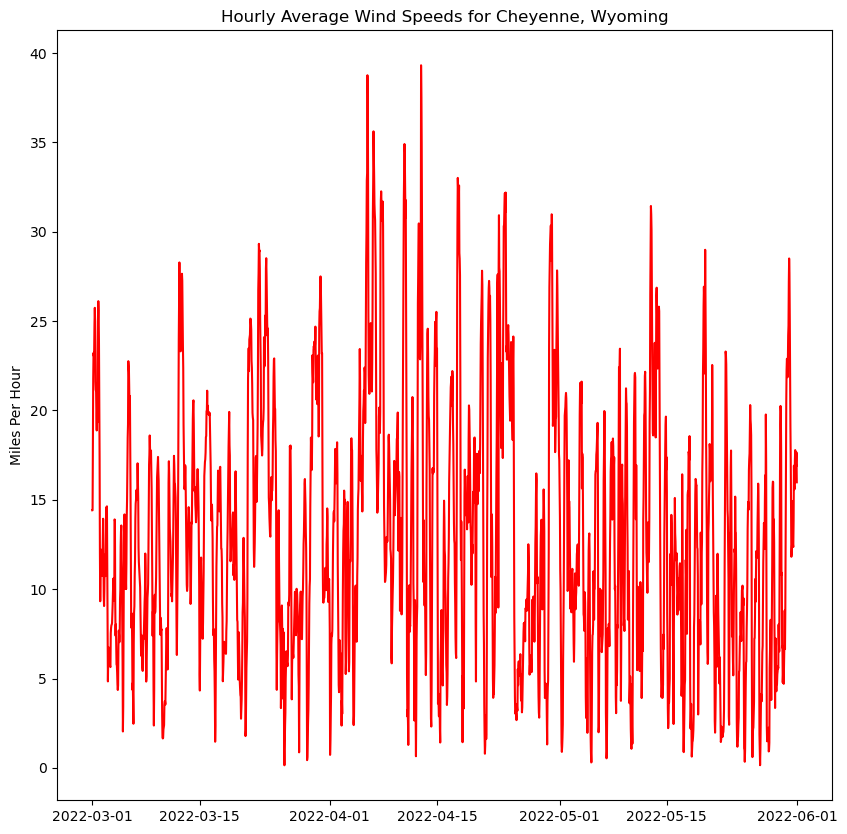

In [27]:
figure = plot_winds(u_values, v_values, ds_u.time)

plt.show()

Once the work is done, we can let go of the Dask cluster with `cluster.close()`.

In [28]:
SAVE_PLOT = True
if SAVE_PLOT:
    plotfile = f'./GLADE_ex-pic-1-23-2024.png'
    figure.savefig(plotfile, dpi=100)

In [29]:
cluster.close()